# 전환 예측 모델 프로젝트
* OO온라인 교육은 10일간 무료체험 서비스를 제공하고 있다. M월 한달간 발생한 무료체험자들의 온라인 학습활동 데이터를 활용하여 무료체험자들의 유료회원 전환 가능성을 예측하는 모델을 개발해보자.

1. 1일차 활동데이터를 활용하여 2일차에도 활동을 할 것인지 예측하는 모델을 만든다
2. 전체 활동 데이터를 창의적으로 활용하여 최종 전환 여부를 예측하는 모델을 만든다
- 데이터의 전체적 현황/분포를 확인하는 프로파일링 작업부터 진행하고, Logistics Regression 모델용 features 선정해서 구현한다.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from scipy.optimize import minimize
from collections import OrderedDict

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
# 값이 0 또는 1 이므로 로지스틱 회귀를 사용함

In [2]:
df = pd.read_csv("C:/Users/rltmdals/Downloads/user_action_10days.csv")

In [3]:
df_fillnan = df.fillna(999)
str_expr = "(day1 != 999) or \
    (day2 != 999) or \
    (day3 != 999) or \
    (day4 != 999) or \
    (day5 != 999) or \
    (day6 != 999) or \
    (day7 != 999) or \
    (day8 != 999) or \
    (day9 != 999) or \
    (day10 != 999)" 
df_q = df_fillnan.query(str_expr)
df_q.head()

,user_id,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,subscribe
0,fa2ad653-e7d9-4250-8db0-c62c962ccd3f,SMSMFEESMSMSSMSMJEFEFJSMSMSSMSMSMSFJESJFEJSGEH...,SMSMSJFESSMSEFEEJJFEI,999,999,SEJFSMSMSMSJJJJEFSFEJSMSMSSMFESMS,ELLLLLLLLLLLLKKKKKSMSMSEJFSJEFSMSMSSSSSMSMSEJF...,SMSMJFEEJFSMSMSSMSSMSMSEJFSFEJSMSMSSSMSMSEJFSF...,999,999,999,0
1,695dbd71-59ee-427e-aa64-4ff7afd1e519,E,999,999,999,999,999,999,999,999,999,0
2,695016e2-4c93-4d57-868e-a2b218519b6c,SMSMSSMSMSSMSMSMSFJKKKEKKKKSJFESMSMS,999,999,999,999,999,999,999,999,999,0
3,e7d6135d-3b19-4655-893d-23adb79d227b,IJJJJIJJJJJJJJIJJJLLJJJJIGJJFMMMEFEE,999,EKKKKKKLJFMMMEELELFELLEJJJJJJEJJIJLLLFIJJJJIJJ...,ELELLFEIJJIJJJJJJJJJJJJJLIJJJJJJIFEJFMMM,EJFMMEJFMMMEFILIFIILIIEIFIIIEEIG,999,EJGJ,999,999,999,0
4,6b8a2ed4-5eb7-4530-91ec-512c03907a1a,EFL,SMSSMSSMSMSSMSMSSMEFS,EFSMSMSSMSMSSMEFSMSMSMSSMFISSMLLELLLFSMFESMS,SMEFSSSMSSMFESMSMSMSSSMEFSSMEFSSMFESMSMSMSMSMS...,SSMSMSMSMSSMSMSMSMSSMSMSMSSMSMSMSSSSMSSSMFESMEFSS,SMSSMEJJJFSSMEFS,999,999,999,999,0


## 값 정리표
종류 | 전체 칼럼 갯수 | 'subscribe'(0) | 'subscribe'(1)
---:|:---:|:---:|:---
원본(df)|30960|29993|967
모두 nan(df_notq)|26795|26783|12
하나라도 nan이 아님(df_q)|4165|3210|955


* user_id 중복없음

# 1번 진행

In [4]:
def str_set(x):
    if type(x) == str:
        s = x
        a = ''.join(OrderedDict.fromkeys(s))
        # 중복은 없애지만 순서는 유지함
        return a
    else:
        return x

In [5]:
df_1 = df_q.copy()
df_1['day2'] = df_1['day2'].apply(lambda x: 1 if x != 999 else 0)
df_1['day1'] = df_1['day1'].apply(lambda x: str_set(x))
df_1 = df_1[['day1', 'day2']]
df_1

,day1,day2
0,SMFEJGHK,1
1,E,0
2,SMFJKE,0
3,IJLGFME,0
4,EFL,1
...,...,...
4160,SMFEK,0
4161,S,0
4162,SMEJFL,0
4163,EFIMJSGH,0


In [33]:
df_1['day1'].apply(lambda x: len(x)).max()
# column 10개 만들기

10

In [6]:
df_1['str1'] = df_1['day1'].apply(lambda x: x[0] if len(x) >= 1 else 0)
df_1['str2'] = df_1['day1'].apply(lambda x: x[1] if len(x) >= 2 else 0)
df_1['str3'] = df_1['day1'].apply(lambda x: x[2] if len(x) >= 3 else 0)
df_1['str4'] = df_1['day1'].apply(lambda x: x[3] if len(x) >= 4 else 0)
df_1['str5'] = df_1['day1'].apply(lambda x: x[4] if len(x) >= 5 else 0)
df_1['str6'] = df_1['day1'].apply(lambda x: x[5] if len(x) >= 6 else 0)
df_1['str7'] = df_1['day1'].apply(lambda x: x[6] if len(x) >= 7 else 0)
df_1['str8'] = df_1['day1'].apply(lambda x: x[7] if len(x) >= 8 else 0)
df_1['str9'] = df_1['day1'].apply(lambda x: x[8] if len(x) >= 9 else 0)
df_1['str10'] = df_1['day1'].apply(lambda x: x[9] if len(x) >= 10 else 0)
df_1

,day1,day2,str1,str2,str3,str4,str5,str6,str7,str8,str9,str10
0,SMFEJGHK,1,S,M,F,E,J,G,H,K,0,0
1,E,0,E,0,0,0,0,0,0,0,0,0
2,SMFJKE,0,S,M,F,J,K,E,0,0,0,0
3,IJLGFME,0,I,J,L,G,F,M,E,0,0,0
4,EFL,1,E,F,L,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4160,SMFEK,0,S,M,F,E,K,0,0,0,0,0
4161,S,0,S,0,0,0,0,0,0,0,0,0
4162,SMEJFL,0,S,M,E,J,F,L,0,0,0,0
4163,EFIMJSGH,0,E,F,I,M,J,S,G,H,0,0


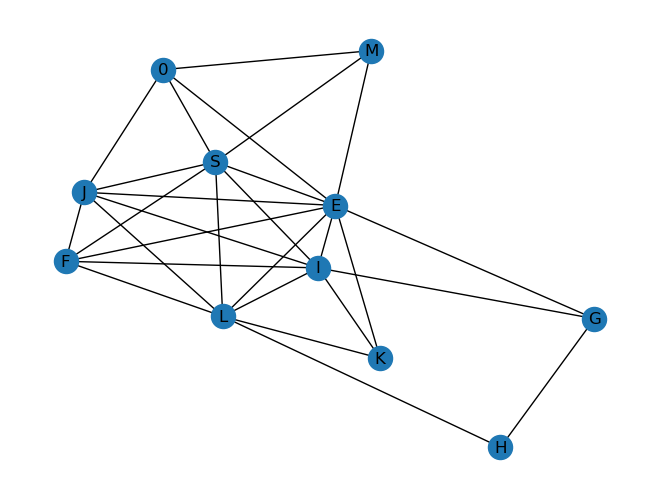

In [20]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'str1': df_1['str1'], 'str2':df_1['str2'], 'str3':df_1['str3'] })
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'str1', 'str2', 'str3')
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()


# Kor_Label Seq_Code
# 영상시작 E
# 영상완료 F
# 영상정지 G
# 영상재개 H
# 영상반복 I
# 구간이동 J
# 속도조절 K
# 볼륨조절 L
# 메뉴이동 M
# 학습확인 S
# 학습 종료 0

# 학습코드 연결 부분
# 최대 값 6개

In [7]:
# one-hot encoding

def change_value(x):
    if x == 'S':
        return 1
    if x == 'M':
        return 2
    if x == 'G':
        return 3
    if x == 'E':
        return 4
    if x == 'F':
        return 5 
    if x == 'H':
        return 6
    if x == 'L':
        return 7
    if x == 'K':
        return 8
    if x == 'J':
        return 9
    if x == 'I':
        return 10
    if x == 0:
        return 0

In [8]:
col_list = ['str1', 'str2', 'str3', 'str4', 'str5', 'str6', 'str7', 'str8', 'str9', 'str10']

for i in col_list:
    df_1[i] = df_1[i].apply(lambda x: change_value(x))
    
df_1

,day1,day2,str1,str2,str3,str4,str5,str6,str7,str8,str9,str10
0,SMFEJGHK,1,1,2,5,4,9,3,6,8,0,0
1,E,0,4,0,0,0,0,0,0,0,0,0
2,SMFJKE,0,1,2,5,9,8,4,0,0,0,0
3,IJLGFME,0,10,9,7,3,5,2,4,0,0,0
4,EFL,1,4,5,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4160,SMFEK,0,1,2,5,4,8,0,0,0,0,0
4161,S,0,1,0,0,0,0,0,0,0,0,0
4162,SMEJFL,0,1,2,4,9,5,7,0,0,0,0
4163,EFIMJSGH,0,4,5,10,2,9,1,3,6,0,0


## 표준화 / 정규화
https://velog.io/@kjh1337/Data-Scaling-%EB%8D%B0%EC%9D%B4%ED%84%B0-%ED%91%9C%EC%A4%80%ED%99%94Standardization
1. Standard Scaler
2. MinMax Scaler
3. Robust Scaler
4. MinAbs Scaler

In [70]:
day = df_1[['str1', 'str2', 'str3', 'str4', 'str5', 'str6', 'str7', 'str8', 'str9', 'str10']]
sub = df_1[['day2']]

# train / test 분리하기
train_features, test_features, train_labels, test_labels = train_test_split(day, sub, test_size=0.25,random_state=0)

# 모델 생성 및 평가하기
model = LogisticRegression(random_state=0)  
model.fit(train_features, train_labels.values.ravel())

# cmtx
Y_pred=model.predict(test_features)

print(accuracy_score(Y_pred, test_labels))


# min-max
# 0.6564299424184261
# 589, 79
# 279, 95

# standard
# 0.6573896353166987

# Robust
# 0.6573896353166987

# MinAbs
# 0.6564299424184261

0.6573896353166987


In [72]:
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

day = df_1[['str1', 'str2', 'str3', 'str4', 'str5', 'str6', 'str7', 'str8', 'str9', 'str10']]
sub = df_1[['day2']]
# train / test 분리하기
X_train, X_test, Y_train, Y_test = train_test_split(day, sub, test_size=0.25,random_state=0)

sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test =sc.transform(X_test)


# 모델 생성 및 평가하기
model = LogisticRegression(random_state=0)  
model.fit(X_train, Y_train.values.ravel())

Y_pred=model.predict(X_test)

#cmtx
cmtx = pd.DataFrame(
    confusion_matrix(Y_test,Y_pred, labels=[1, 0]), 
    index=['true:day2(1)', 'true:not day2(0)'], 
    columns=['pred:day2(1)', 'pred:not day2(0)']
)


print(accuracy_score(Y_test,Y_pred))

cmtx

# standard
# 0.6573896353166987

# Robust
# 0.6573896353166987

# MinAbs
# 0.6564299424184261

0.6573896353166987


,pred:day2(1),pred:not day2(0)
true:day2(1),589,79
true:not day2(0),278,96


# 2번 진행

In [31]:
df_lenq = df_q.copy()
def str_len(x):
    if type(x) == str:
        return len(x)
    else:
        return 0

col_list = ['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']
for col in col_list:
    df_lenq[col] = df_lenq[col].apply(lambda x: str_len(x))
df_lenq

,user_id,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,subscribe
0,fa2ad653-e7d9-4250-8db0-c62c962ccd3f,85,21,0,0,33,66,82,0,0,0,0
1,695dbd71-59ee-427e-aa64-4ff7afd1e519,1,0,0,0,0,0,0,0,0,0,0
2,695016e2-4c93-4d57-868e-a2b218519b6c,36,0,0,0,0,0,0,0,0,0,0
3,e7d6135d-3b19-4655-893d-23adb79d227b,36,0,62,40,32,0,4,0,0,0,0
4,6b8a2ed4-5eb7-4530-91ec-512c03907a1a,3,21,44,80,49,16,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4160,2f89514e-179b-4617-a701-d9898fbdb8bb,18,0,0,0,0,0,0,0,0,0,0
4161,7a96b199-bc6b-477d-98b7-53da66823d98,1,0,0,0,0,0,0,0,0,0,0
4162,809833f7-cdcb-4842-b200-e00d8ca4adc7,33,0,0,0,0,0,0,0,0,0,0
4163,dfa237f6-2b3c-4659-98a4-0dc300dee64d,49,0,0,0,0,0,0,0,0,0,0


In [49]:
day = df_lenq[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]
sub = df_lenq[['subscribe']]

# train / test 분리하기
train_features, test_features, train_labels, test_labels = train_test_split(day, sub, test_size=0.25,random_state=0)

# 모델 생성 및 평가하기
model = LogisticRegression(random_state=0)  
model.fit(train_features, train_labels.values.ravel())


# cmtx
Y_pred=model.predict(test_features)

print(accuracy_score(Y_pred, test_labels))

0.7984644913627639


In [50]:
print(model.coef_)

[[0.00123227 0.00191666 0.00056951 0.00203619 0.00036524 0.00391351
  0.00230556 0.00854675 0.01042121 0.00790689]]


In [75]:
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

day = df_lenq[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]
sub = df_lenq[['subscribe']]
# train / test 분리하기
X_train, X_test, Y_train, Y_test = train_test_split(day, sub, test_size=0.25,random_state=0)

sc=RobustScaler()

X_train=sc.fit_transform(X_train)
X_test =sc.transform(X_test)


# 모델 생성 및 평가하기
model = LogisticRegression(random_state=0)  
model.fit(X_train, Y_train.values.ravel())

Y_pred=model.predict(X_test)

#cmtx
cmtx = pd.DataFrame(
    confusion_matrix(Y_test,Y_pred, labels=[1, 0]), 
    index=['true:day2(1)', 'true:not day2(0)'], 
    columns=['pred:day2(1)', 'pred:not day2(0)']
)


print(accuracy_score(Y_test,Y_pred))


# standard
# 0.7975047984644914

# min-max
# 0.7879078694817658

# Robust
# 0.7975047984644914

# MaxAbs
# 0.7879078694817658
# 모든 값은 -1과 1사이가 되며, 모든 데이터가 양수일 경우에는 MinMax Scaler와 같은 결과값이 됩니다.

print(model.coef_)
# day9가 제일 높음
# day8이 그 다음
cmtx

0.7975047984644914
[[0.06506651 0.11100761 0.02363609 0.0732084  0.01126256 0.1055657
  0.0555286  0.16220839 0.01042641 0.00790685]]


,pred:day2(1),pred:not day2(0)
true:day2(1),53,177
true:not day2(0),34,778


In [61]:
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

day = df_lenq[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]
sub = df_lenq[['subscribe']]
# train / test 분리하기
X_train, X_test, Y_train, Y_test = train_test_split(day, sub, test_size=0.25,random_state=0)

sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test =sc.transform(X_test)


# 모델 생성 및 평가하기
model = LogisticRegression(random_state=0)  
model.fit(X_train, Y_train.values.ravel())

Y_pred=model.predict(X_test)

#cmtx
cmtx = pd.DataFrame(
    confusion_matrix(Y_test,Y_pred, labels=[1, 0]), 
    index=['true:day2(1)', 'true:not day2(0)'], 
    columns=['pred:day2(1)', 'pred:not day2(0)']
)


print(accuracy_score(Y_test,Y_pred))


# standard
# 0.7975047984644914

# min-max
# 0.7879078694817658

# Robust
# 0.7975047984644914

# MaxAbs
# 0.7879078694817658
# 모든 값은 -1과 1사이가 되며, 모든 데이터가 양수일 경우에는 MinMax Scaler와 같은 결과값이 됩니다.

print(model.coef_)
# day9가 제일 높음
# day8이 그 다음
cmtx

0.7975047984644914
[[0.06813391 0.12662792 0.03189585 0.10794054 0.01732572 0.1613357
  0.09500766 0.3366782  0.45843415 0.29569163]]


,pred:day2(1),pred:not day2(0)
true:day2(1),53,177
true:not day2(0),34,778


In [76]:
prob1=model.predict_proba(X_train)[:,1]
prob1
def objective_func(cutoff):
    
    Y_pred_new_cutoff = [1 if i > cutoff else 0 for i in prob1]

    return(1-accuracy_score(Y_train,Y_pred_new_cutoff))

opt_res = minimize(objective_func, 1, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

print("cutoff point(최적화 솔루션):", opt_res.x)
print("정확도(accuracy):", 1-opt_res.fun)

Optimization terminated successfully.
         Current function value: 0.195325
         Iterations: 31
         Function evaluations: 80
cutoff point(최적화 솔루션): [0.3125]
정확도(accuracy): 0.8046749919948767


In [78]:
df_lenq

,user_id,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,subscribe
0,fa2ad653-e7d9-4250-8db0-c62c962ccd3f,85,21,0,0,33,66,82,0,0,0,0
1,695dbd71-59ee-427e-aa64-4ff7afd1e519,1,0,0,0,0,0,0,0,0,0,0
2,695016e2-4c93-4d57-868e-a2b218519b6c,36,0,0,0,0,0,0,0,0,0,0
3,e7d6135d-3b19-4655-893d-23adb79d227b,36,0,62,40,32,0,4,0,0,0,0
4,6b8a2ed4-5eb7-4530-91ec-512c03907a1a,3,21,44,80,49,16,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4160,2f89514e-179b-4617-a701-d9898fbdb8bb,18,0,0,0,0,0,0,0,0,0,0
4161,7a96b199-bc6b-477d-98b7-53da66823d98,1,0,0,0,0,0,0,0,0,0,0
4162,809833f7-cdcb-4842-b200-e00d8ca4adc7,33,0,0,0,0,0,0,0,0,0,0
4163,dfa237f6-2b3c-4659-98a4-0dc300dee64d,49,0,0,0,0,0,0,0,0,0,0
